# 2018 PHM Data Challenge 

## Introduction

This data set examines the fault behavior of an ion mill etch tool used in a wafer manufacturing process (see references at the end of this document). The process of ion mill etching typically consists of the following steps:

    Inserting a wafer into the mill
    Configure wafer settings (rotation speed, angles, beam current / voltages, etc.)
    Processing the wafer for a set amount of time
    Repeat 2 or 3 for different steps of recipe
    Remove wafer from mill

An ion source generates ions that are accelerated through an electric field using a series of grids set at specific voltages. This creates an ion beam that travels and eventually strikes the wafer surface. Material is removed from the wafer when ions hit the wafer surface. The wafer is placed on a rotating fixture that can be tilted at different angles facing the incoming ion beam. The wafer can be shielded from the ion beam until ready for milling operation to commence using a shutter mechanism as shown in Figure 2. A Particle Beam Neutralizer (PBN) control system influences the ion beam shape / ion distribution as it travels to the wafer surface.

The wafer is cooled by a helium / water system called flowcool. The cooling system passes helium gas behind the wafer at a specified flow rate. The helium gas is indirectly cooled by a water system. The wafer and fixture o-ring separates the flowcool gas from the ion mill vacuum chamber.

Many different failure mechanisms can be present in this system including leaks between flowcool and ion mill chambers, electric grid wear, ion chamber wear, etc. It would be beneficial to predict where and when these failures occur and schedule downtime of these ion mills for maintenance operations.

The objective of this data challenge is to build a model from time series sensor data collected from various ion mill etching tools operating under various conditions and settings.

    Diagnose failures (i.e. detect and identify)
    Determine time remaining until next failure (i.e. predict remaining useful life)

Predictions of time-to-failure at a specific time should only use time-series data from current and past times. In other words, do not try to predict the point of failure first and then backtrack through time to determine time-to-failure predictions.


# Dataset

The function `rul_pm.datasets.PHMDataset2018.prepare_raw_dataset(path: Path)`  is in charge of downloading the data and decompress all the files. 
Whereas the function `rul_pm.datasets.PHMDataset2018.prepare_dataset(dataset_path: Path)` split the raw dataset is run to failure cycles.

The dataset structure has two folder 
* test
 * 01_M02_DC_test.csv
* train
    * train_faults/
        * 01_M01_train_fault_data.csv
        * 01_M02_train_fault_data.csv 
    * 01_M01_DC_train.csv
    * 01_M02_DC_train.csv
    * ....

Inside the train folders the files called `%%_%%%_DC_train.csv` contains the raw sensors of the machine. Each file corrresponds to a machcine. The files inside train/train_faults called `%%_%%%_train_fault_data.csv`contains for each machine the list of recorded failures. These files contains three columns: 
* time: Timestamp of the failure
* fault_name: Failure type
* Tool: Tool which suffered the failure ( constant for each file since each file correspond to one machine).

## Pre-processing

```python
def merge_data_with_faults(
    data_file: Union[str, Path], fault_data_file: Union[str, Path]
) -> pd.DataFrame:
    data = pd.read_csv(data_file).dropna().set_index("time")

    fault_data = (
        pd.read_csv(fault_data_file).drop_duplicates(subset=["time"]).set_index("time")
    )
    fault_data["fault_number"] = range(fault_data.shape[0])
    return pd.merge_asof(data, fault_data, on="time", direction="forward").set_index(
        "time"
    )

for data_file, fault_data_file in file_list:
    data = merge_data_with_faults(data_file, fault_data_file)
    for life_index, life_data in data.groupby("fault_number"):
        life = life_data.copy()
        life["RUL"] = np.arange(life.shape[0] - 1, -1, -1)
        failure_type = life_data["fault_name"]
        save_cycle(life_index, life, failure_type)
```

## Import

In [23]:
import matplotlib.pyplot as plt
import seaborn as sbn

from rul_pm.datasets.PHMDataset2018 import PHMDataset2018
import rul_pm.datasets.PHMDataset2018 as IonMillEtchToolDataset
from rul_pm.graphics.utils.annotations import add_vertical_lines_annotations
import numpy as np
import pandas as pd

In [4]:
sbn.set()

# Dataset

In [2]:
dataset = PHMDataset2018()

## Number of lives in the dataset

In [4]:
len(dataset)

901

In [5]:
## Number of tools in the dataset

In [6]:
q = dataset.lives['Tool'].value_counts()
len(q)

20

Text(0, 0.5, 'Number of cycles')

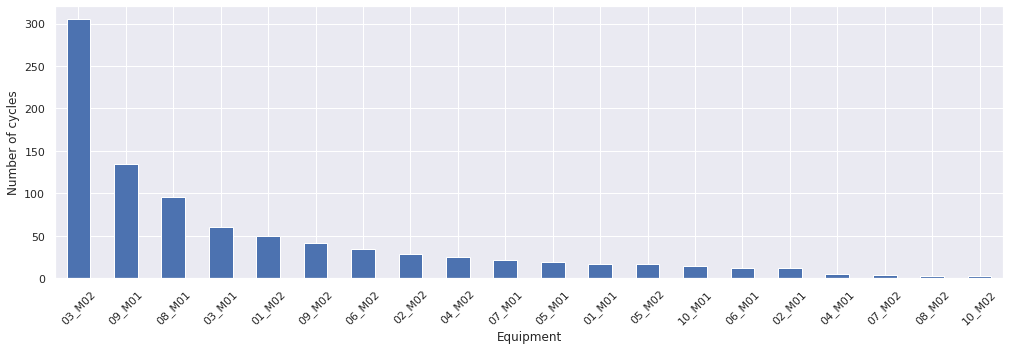

In [20]:
fig, ax = plt.subplots(figsize=(17, 5))
q.plot.bar(ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45);
ax.set_xlabel('Equipment')
ax.set_ylabel('Number of cycles')

## Failure types

Text(0, 0.5, 'Number of cycles')

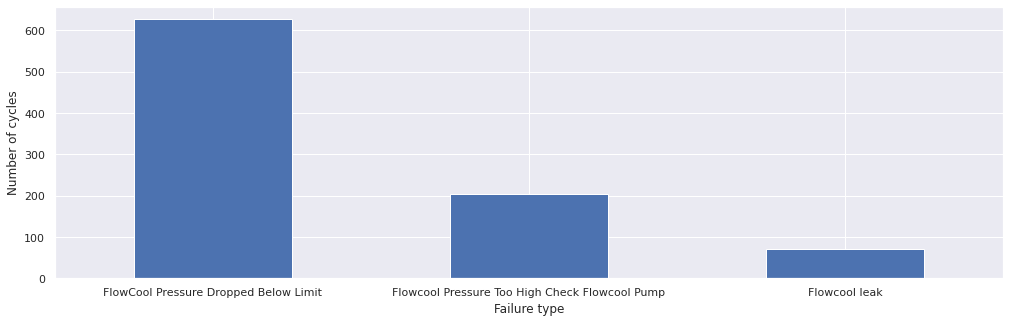

In [26]:
q = dataset.lives['Failure Type'].value_counts()
fig, ax = plt.subplots(figsize=(17, 5))
q.plot.bar(ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0);
ax.set_xlabel('Failure type')
ax.set_ylabel('Number of cycles')

## Equipment and failure types

<AxesSubplot:xlabel='Failure Type', ylabel='Tool'>

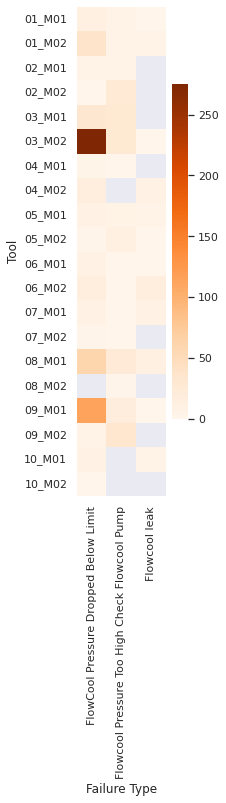

In [28]:
q = (dataset.lives[['Failure Type', 'Tool']]
 .groupby(['Failure Type', 'Tool'])
 .size()
 .reset_index()
 .pivot(index=['Failure Type'], columns=['Tool'])
)
q.columns = q.columns.droplevel()

fig, ax = plt.subplots(figsize=(2, 9))
sbn.heatmap(q.T, ax=ax, vmin=0, cmap=plt.get_cmap('Oranges'))

# Most popular equipment and failiure type

Flow Cool Pressure Dropped Below Limit and Tool 03M02

In [6]:
dataset = PHMDataset2018(
            failure_types=IonMillEtchToolDataset.FailureType.FlowCoolPressureDroppedBelowLimit,
            tools='03_M02'
        )

## Number of lives

In [33]:
len(dataset)

275

## Number of samples for each cycle

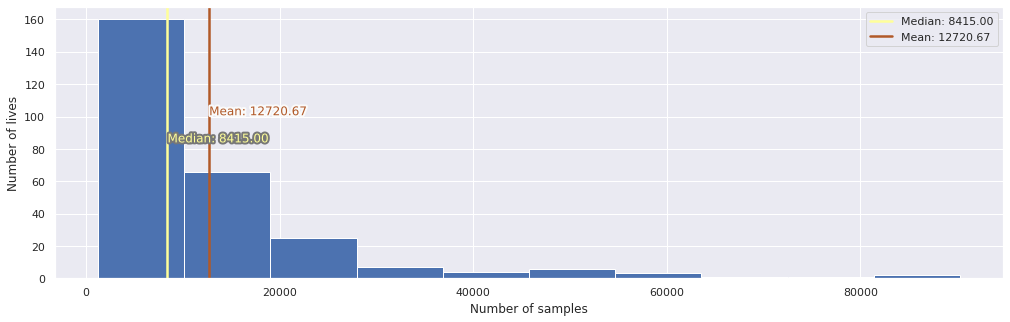

In [7]:
fig, ax = plt.subplots(figsize=(17, 5))
samples = dataset.lives['Number of samples']
ax.hist(samples)
ax.set_xlabel('Number of samples')
ax.set_ylabel('Number of lives')
add_vertical_lines_annotations(
    ax, 
    [
        (np.median(samples), "Median"),
        (np.mean(samples), 'Mean')
    ])

## Sample rate

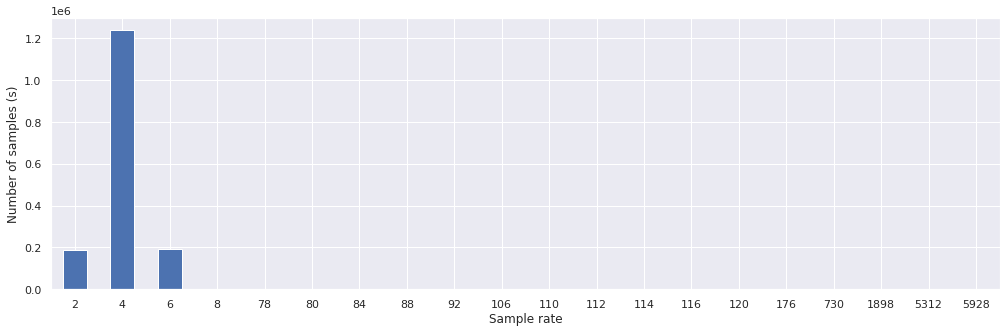

In [30]:
total_counts = {}
for life in dataset:
    counts = {
        sample_rate:count 
         for sample_rate,count in 
         zip(*np.unique(np.diff(dataset[0].index), return_counts=True))
    }
    for k in counts.keys():
        if k not in total_counts:
            total_counts[k] = 0
        total_counts[k] += counts[k]
fig, ax = plt.subplots(figsize=(17, 5))
pd.Series(total_counts).plot.bar(ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_xlabel('Sample rate')
ax.set_ylabel('Number of samples (s)');

Since most of the samples are separated by 4 seconds it's safe to assume that each st. RUL as the number of samples, we  can then compute as number of samples *4

## Categorical features

## Numerical features

# Raw features

# Feature transformer

## Feature Analysis